# Include lib

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchinfo
import glob
import matplotlib.pyplot as plt
import cv2
import numpy
import os
from os import listdir
import datetime

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models

from PIL import Image, ImageOps

# To use GPU

In [2]:
device = torch.device("cuda")

In [3]:
resnet = torchvision.models.resnet50()
torchinfo.summary(resnet, depth=5, input_size=(128, 3, 64,64), row_settings=["var_names"], verbose=0, col_names=[
"input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
ResNet (ResNet)                          [128, 3, 64, 64]          [128, 1000]               --                             --                   --                        --                        True
├─Conv2d (conv1)                         [128, 3, 64, 64]          [128, 64, 32, 32]         9,408                       0.04%                   [7, 7]                    1,233,125,376             True
├─BatchNorm2d (bn1)                      [128, 64, 32, 32]         [128, 64, 32, 32]         128                         0.00%                   --                        16,384                    True
├─ReLU (relu)                            [128, 64, 32, 32]         [128, 64, 32, 32]         --                             --                   --                        --              

# Prepareting Dataset

In [4]:
BATCH_SIZE = 16
EPOCH = 10

In [5]:
PATH_TO_TRAIN = ".\sy_dataset2"
PATH_TO_TEST = ".\sy_test"

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Velor139\AppData\Local\Temp\ipykernel_14324\1048782752.py:1: SyntaxWarning: invalid escape sequence '\s'
  PATH_TO_TRAIN = ".\sy_dataset2"
C:\Users\Velor139\AppData\Local\Temp\ipykernel_14324\1048782752.py:2: SyntaxWarning: invalid escape sequence '\s'
  PATH_TO_TEST = ".\sy_test"


In [6]:
labels = dict((name, index) for (index, name) in enumerate(listdir(PATH_TO_TRAIN)))

In [7]:
transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

In [8]:
class Image_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_direcrory, labels, transform=True):
        self.image_direcrory = image_direcrory
        self.labels = labels
        self.transform = transform

        self.paths = list()
        self.labels = list()
        for label in labels: 
            elements = glob.glob(os.path.join(image_direcrory, label, "*.jpg"))
            self.paths.extend(elements)
            self.labels.extend([labels.get(label)] * len(elements))
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        with open(self.paths[index], "rb") as file:
            image = Image.open(file).convert("RGB")
        if self.transform:
            image = transformation(image)
        return image, torch.tensor(self.labels[index], dtype=torch.long)

In [9]:
dataset_train = Image_Dataset(PATH_TO_TRAIN, labels)
dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 

# Model

In [10]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False).to(device)
# model.classifier = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(1280, len(labels))
# ).to(device)

In [11]:
model = models.resnet50(pretrained=True)

# Замена последнего слоя на слой для бинарной классификации
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Один выход для бинарной классификации
model = nn.Sequential(model, nn.Sigmoid()) 
model.to(device)

c:\Users\Velor139\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Velor139\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [12]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

-> для закачки Weights

In [13]:
model.load_state_dict(torch.load(".\ivan_model_resnet.pth"))

-> обучение

In [14]:
model.train()
for epoch in range(EPOCH):
    for images, labs in dataloader:
        optimizer.zero_grad()

        images, labs = images.to(device), labs.to(device)

        out = model(images)
        # print(out, labs)
        # print(out.view(-1))
        loss = criterion(out.view(-1), labs.float())
        loss.backward()
        optimizer.step()
        print(f"epoch = {epoch}  loss = {loss} ")

epoch = 0  loss = 0.6531696915626526 
epoch = 0  loss = 0.10381831228733063 
epoch = 0  loss = 0.7372387051582336 
epoch = 0  loss = 0.975947380065918 
epoch = 0  loss = 1.0933181047439575 
epoch = 0  loss = 0.7925224304199219 
epoch = 0  loss = 0.06983257085084915 
epoch = 0  loss = 0.3095513582229614 
epoch = 0  loss = 0.2768353819847107 
epoch = 0  loss = 0.30295318365097046 
epoch = 0  loss = 0.2702210545539856 
epoch = 0  loss = 0.3230033218860626 
epoch = 0  loss = 0.18119379878044128 
epoch = 0  loss = 0.15679478645324707 
epoch = 0  loss = 0.11666569113731384 
epoch = 0  loss = 0.09769867360591888 
epoch = 0  loss = 0.22597922384738922 
epoch = 0  loss = 0.035161957144737244 
epoch = 0  loss = 0.13181018829345703 
epoch = 0  loss = 0.3770698606967926 
epoch = 0  loss = 0.2872389256954193 
epoch = 0  loss = 0.5813876390457153 
epoch = 0  loss = 0.04288387671113014 
epoch = 0  loss = 0.3231794834136963 
epoch = 0  loss = 0.6205692291259766 
epoch = 0  loss = 0.35997799038887024 


-> сохранение Weights

In [15]:
torch.save(model.state_dict(), "ivan_model_resnet.pth")

In [28]:
def test_image(model, img_path, transform):
# Load image and apply transformations
    with open(img_path, "rb") as f:
        img = Image.open(f).convert("RGB")  
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get model output and class probabilities
    output = model(img_tensor)
    # print(output)
    # probs = torch.softmax(output, dim=1)

    # Get predicted class label and class name
    # pred_label = torch.argmax(output, dim=1).item()
    pred_label = output.item()
    # print(output.item())
    # print()
    predicted = 0
    if (pred_label > 0.5):
        predicted = 1 
    # if ()
    class_name = list(labels.keys())[list(labels.values()).index(predicted)]

    # Return predicted label and class probabilities
    return pred_label, class_name

In [37]:
import random
 
number = random.random()  # значение от 0.0 до 1.0

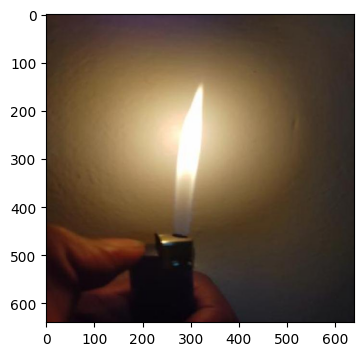

name IMG_20220624_080946_10_jpg.rf.77dfa61b5d5e65b02e676a8c228e8fe9.jpg, out: fire


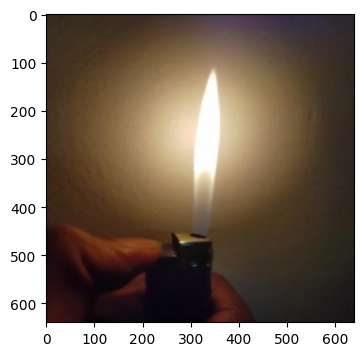

name IMG_20220624_080951_1-Copy_jpg.rf.b35fd7e26be73766e40b6e788e9bacc2.jpg, out: fire


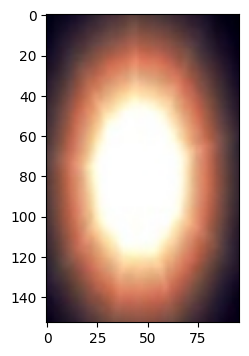

name IMG_20250316_134044.jpg, out: none


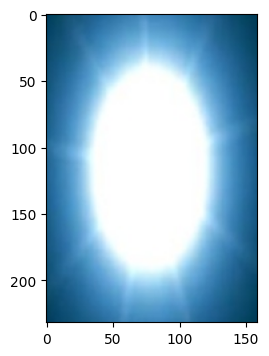

name IMG_20250316_134114.jpg, out: none


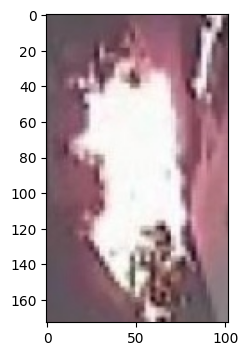

name IMG_20250316_134448.jpg, out: fire


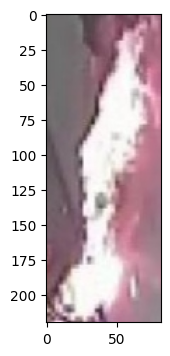

name IMG_20250316_134619.jpg, out: fire


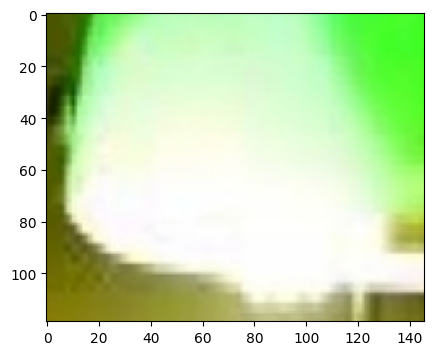

name IMG_20250316_135603.jpg, out: none


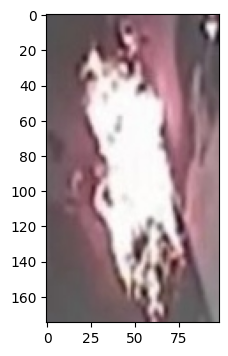

name IMG_20250316_135702.jpg, out: fire


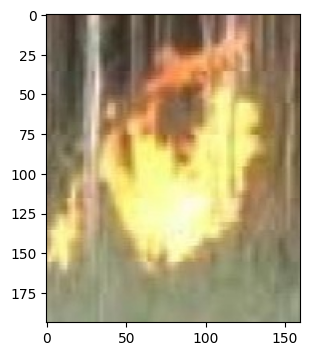

name IMG_20250316_140714.jpg, out: fire


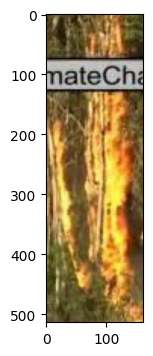

name IMG_20250316_140823.jpg, out: fire


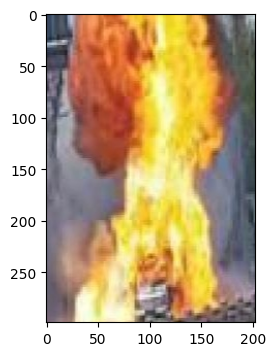

name IMG_20250316_142721.jpg, out: fire


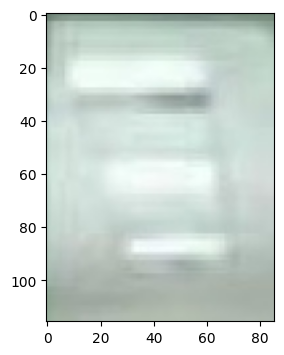

name IMG_20250316_143008.jpg, out: none


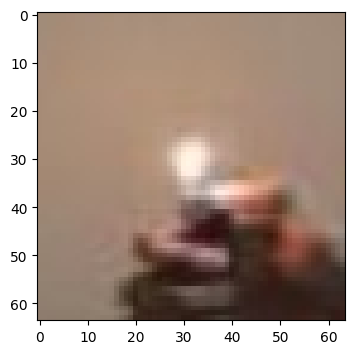

name IMG_20250316_143246.jpg, out: fire


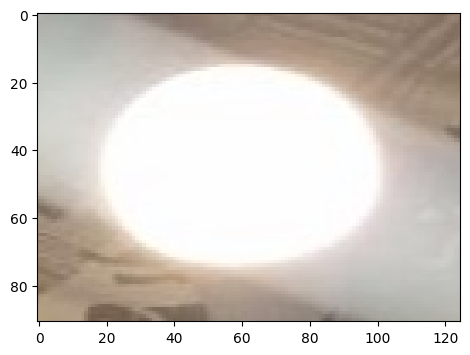

name IMG_20250316_143313.jpg, out: none


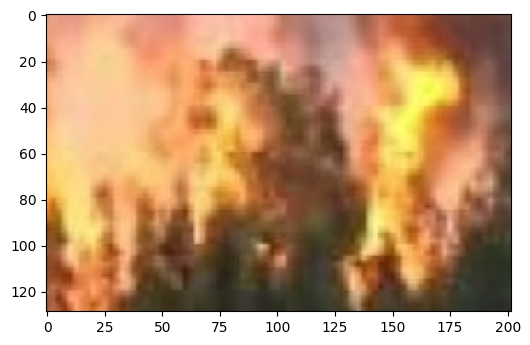

name IMG_20250316_143753.jpg, out: fire


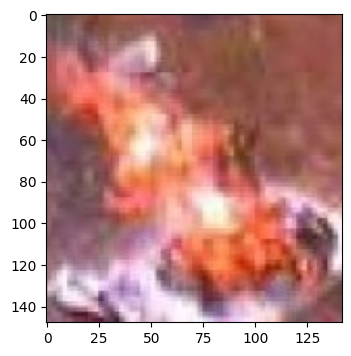

name IMG_20250316_144125.jpg, out: fire


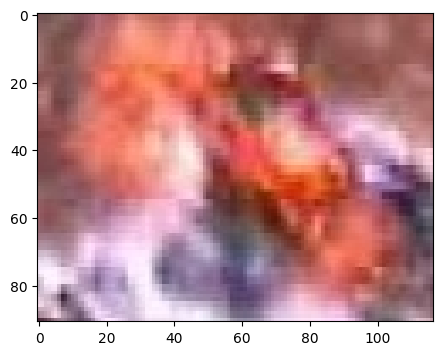

name IMG_20250316_144210.jpg, out: fire


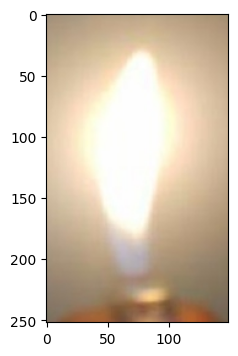

name IMG_20250316_153453.jpg, out: none


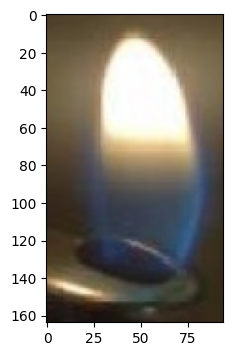

name IMG_20250316_153554.jpg, out: none


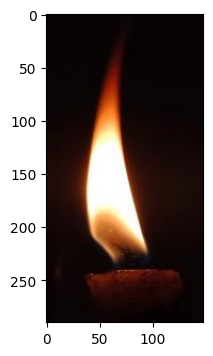

name IMG_20250316_153915.jpg, out: none


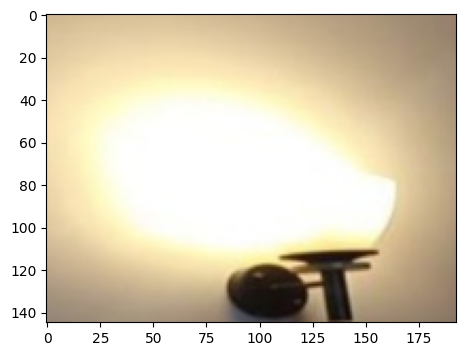

name IMG_20250316_164237.jpg, out: none


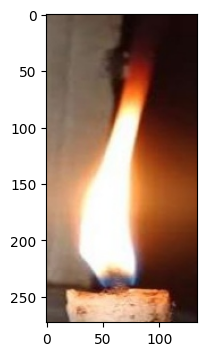

name IMG_20250316_164300.jpg, out: fire


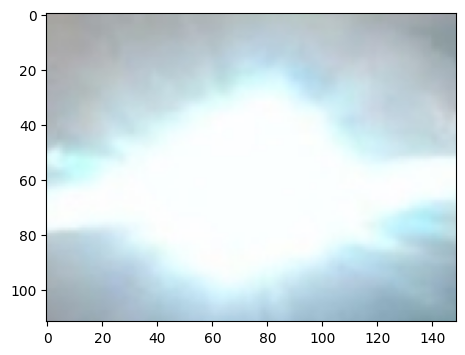

name IMG_20250316_185644.jpg, out: none


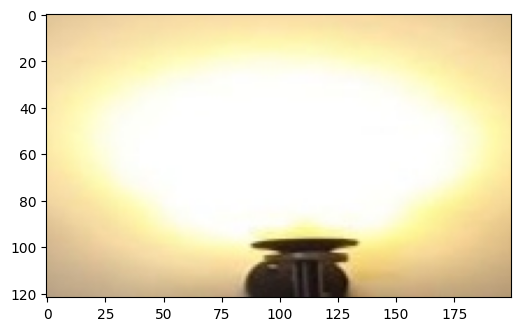

name IMG_20250316_185752.jpg, out: none


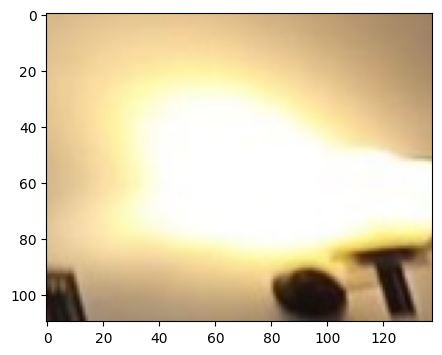

name IMG_20250316_190659.jpg, out: none


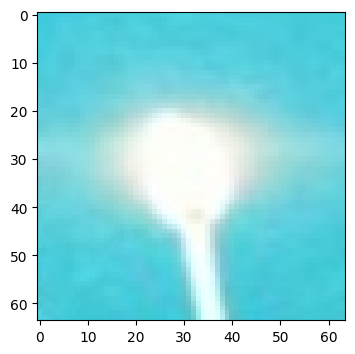

name IMG_20250316_192056.jpg, out: none


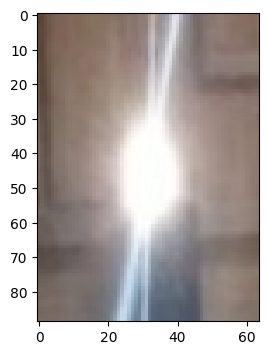

name IMG_20250316_192140.jpg, out: none


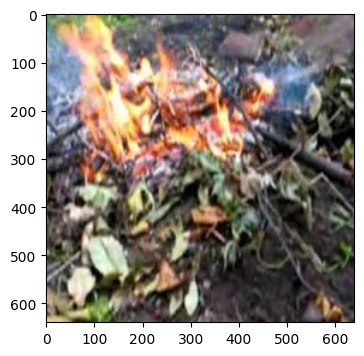

name Img_475_jpg.rf.382c1565d4f6c9877f1501f8ae598486.jpg, out: fire


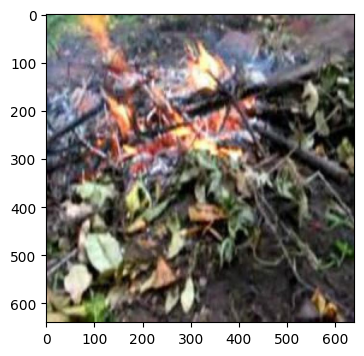

name Img_503_jpg.rf.185998e8efc31a55bb70b833fc919be0.jpg, out: fire


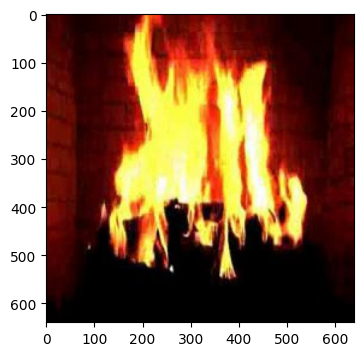

name Img_538_jpg.rf.d5df25187942bd14992ca1e36de13d2e.jpg, out: fire


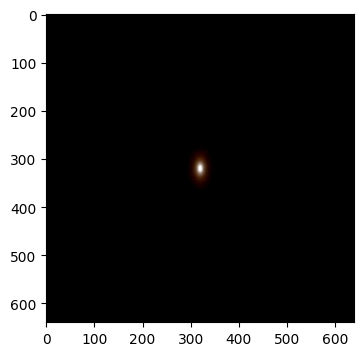

name youtube-101_jpg.rf.15d32f42856b5f500f94145936afe9a7.jpg, out: none


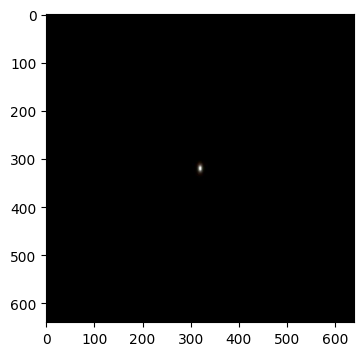

name youtube-160_jpg.rf.0556cfb5e41ecca3e3ddd7aaf9b2f1a8.jpg, out: none


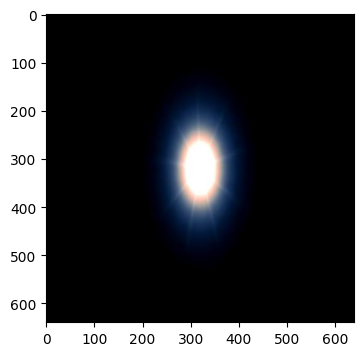

name youtube-393_jpg.rf.601aed1f3b3307ab7acd43d26d53cd33.jpg, out: none


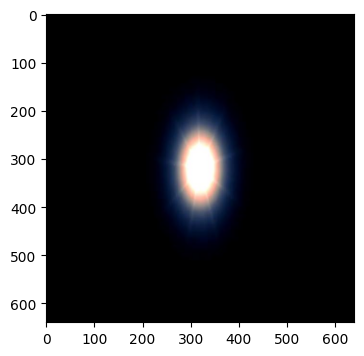

name youtube-427_jpg.rf.7545497313b3ae3d510258b48cd00028.jpg, out: none


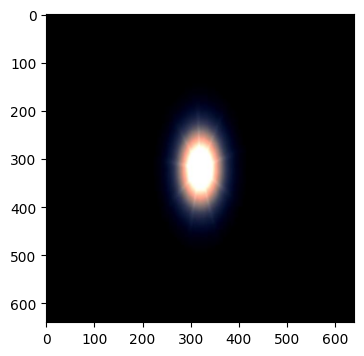

name youtube-494_jpg.rf.3cde0e48d8ef6cc3c6b941d6e58719d8.jpg, out: none


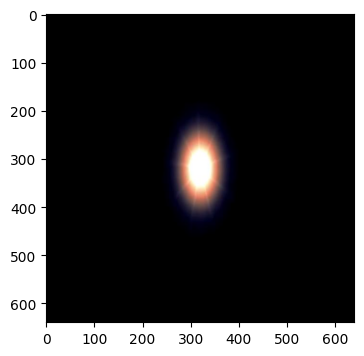

name youtube-495_jpg.rf.5443f1657b6f3252437fbca7fd912283.jpg, out: none


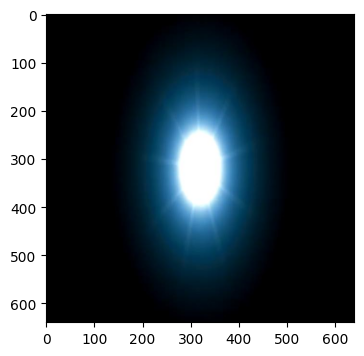

name youtube-530_jpg.rf.004a2eea25ff9ed06a0e21329f0854a2.jpg, out: none


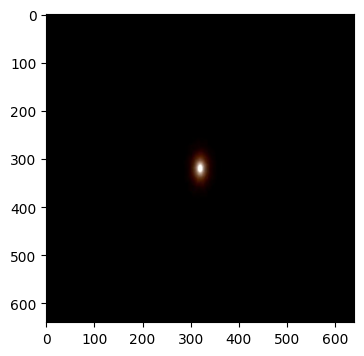

name youtube-621_jpg.rf.2843c9b11903fa50867470770dce158f.jpg, out: none


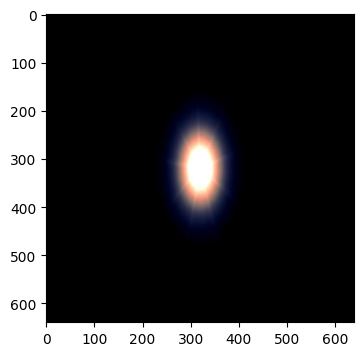

name youtube-626_jpg.rf.ee79b6e6ad71cde50be4cf8489e00737.jpg, out: none


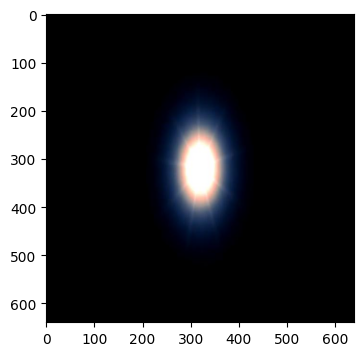

name youtube-667_jpg.rf.28751581cd4381ce5f25cd48488d0091.jpg, out: none


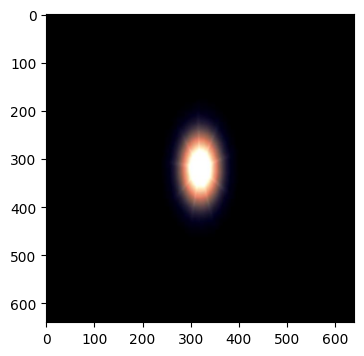

name youtube-795_jpg.rf.9fd1a1cc43c79dc707e8f0fc6c02c4ec.jpg, out: none


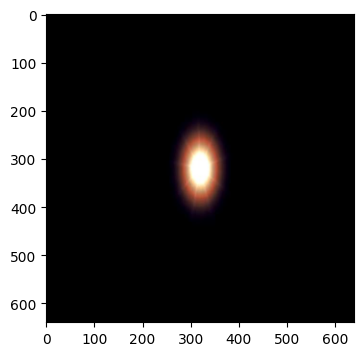

name youtube-796_jpg.rf.8344b0f3981fc9da94146f999e9cc2ae.jpg, out: none


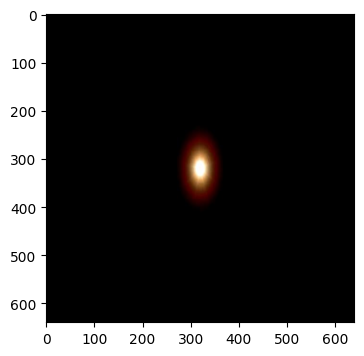

name youtube-898_jpg.rf.3b49d10814a8440da05047c4859f86f8.jpg, out: none


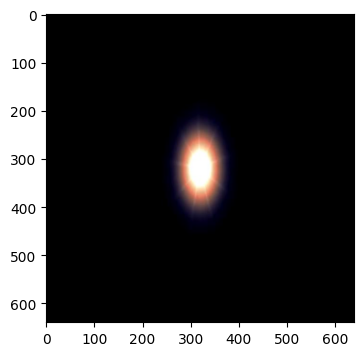

name youtube-915_jpg.rf.2dc80235e5eec5419c3e5f1ab7ec6ba5.jpg, out: none


In [39]:
path = PATH_TO_TEST
yes = 0
no = 0
model.eval()
for i in os.listdir(path):
    number = random.random()
    if (number < 0.1):
        pred_label, class_name = test_image(model, os.path.join(path, i), transformation)
        img = Image.open(PATH_TO_TEST+"\\"+i)
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot()
        ax.imshow(img)
        
        plt.show()
        # if(i.find(class_name) != -1):
        #     yes += 1
        # else:
        #     no +=1
        print(f"name {i}, out: {class_name}")
# print(f"yes {yes}, no {no}")